# Import the needed libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, fowlkes_mallows_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Data Preprocessing
Preprocess the dataset

In [2]:
# Define the image dimensions
IMG_WIDTH, IMG_HEIGHT = 128, 128

# Define the path to the dataset
dataset_path = 'Dataset'

# Define a dictionary to map folder names to class labels
class_labels = {'Mild_Demented': 0, 'Moderate_Demented': 1, 'Non_Demented': 2, 'Very_Mild_Demented': 3}

# Function to load and preprocess images
def load_and_preprocess_images(dataset_path, img_width, img_height):
    images = []
    labels = []
    for class_name, class_label in class_labels.items():
        class_folder = os.path.join(dataset_path, class_name)
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (img_width, img_height))
                images.append(img.flatten())
                labels.append(class_label)
    return np.array(images), np.array(labels)

# Load and preprocess the images
X, y = load_and_preprocess_images(dataset_path, IMG_WIDTH, IMG_HEIGHT)

# Print the shape of the processed data
print(f'Processed data shape: {X.shape}')
print(f'Processed labels shape: {y.shape}')

Processed data shape: (6400, 16384)
Processed labels shape: (6400,)


Visualise the data

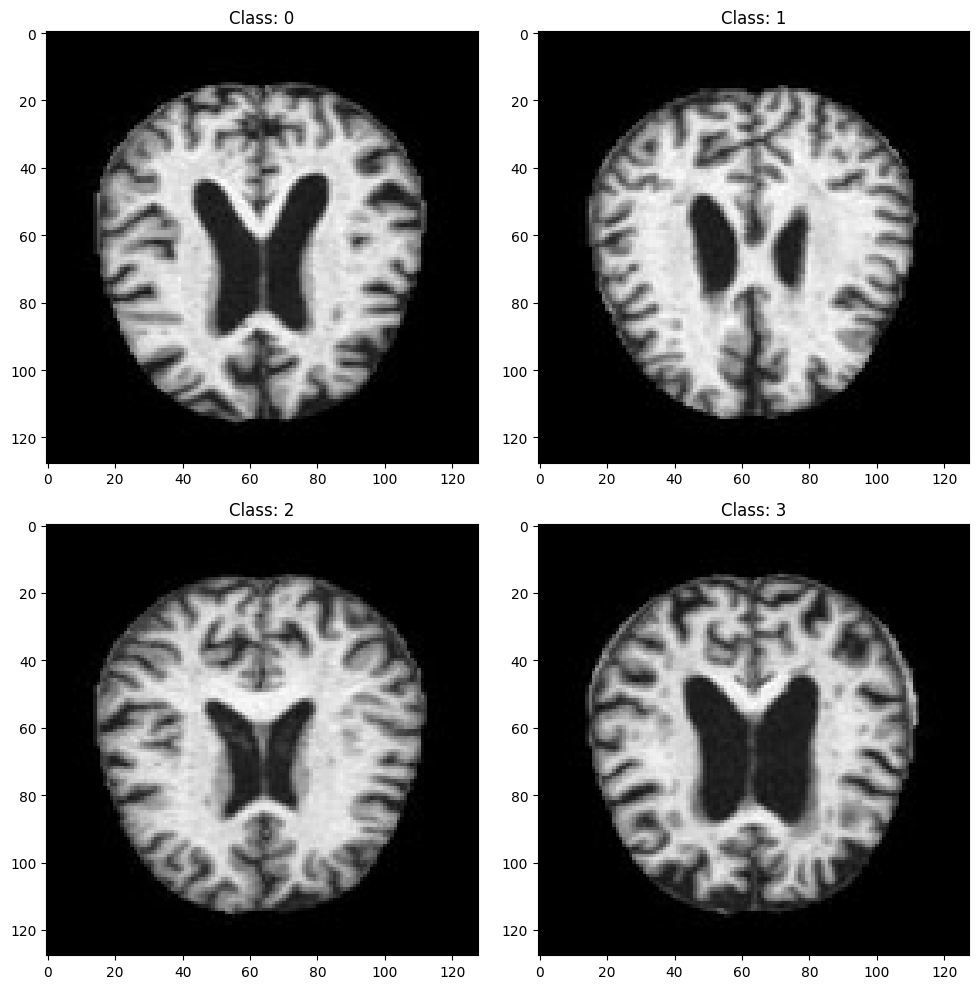

In [3]:
# Select the indices of the images you want to visualize
image_indices = [0, 897, 961, 4161]  

# Create a figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Iterate over the image indices and display each image
for i, ax in enumerate(axes.flat):
    # Extract the vector and reshape it to 128x128
    image_index = image_indices[i]
    image_vector = X[image_index]
    image_2d = image_vector.reshape(128, 128)
    
    # Display the image
    ax.imshow(image_2d, cmap='gray')
    ax.set_title(f'Class: {y[image_index]}')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Plotting Functions
Create functions to visualise the 2D and 3D embeddings

In [4]:
# Define the class labels dictionary
class_labels = {'Mild_Demented': 0, 'Moderate_Demented': 1, 'Non_Demented': 2, 'Very_Mild_Demented': 3}

# Function to plot 2D embedding
def plot_embedding_2d(X, y, title):
    plt.figure(figsize=(10, 8))
    for class_name, class_label in class_labels.items():
        plt.scatter(X[y == class_label, 0], X[y == class_label, 1], label=class_name, alpha=0.7)
    plt.title(title)
    plt.legend()
    plt.show()

# Function to plot 3D embedding
def plot_embedding_3d(X, y, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    for class_name, class_label in class_labels.items():
        ax.scatter(X[y == class_label, 0], X[y == class_label, 1], X[y == class_label, 2], label=class_name, alpha=0.7)
    ax.set_title(title)
    ax.legend()
    plt.show()
    
# Function for plotting the metrics
def plot_metrics(df, metric_name, ylabel):
    plt.figure(figsize=(10, 6))
    plt.bar(df['Algorithm'], df[metric_name], color='skyblue')
    plt.xlabel('Algorithm')
    plt.ylabel(ylabel)
    plt.title(f'{metric_name}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Function for plotting the classification metrics
def plot_classification_results(df, metric):
    plt.figure(figsize=(10, 6))
    plt.bar(df['Algorithm'], df[metric], color='skyblue')
    plt.xlabel('Algorithm')
    plt.ylabel(metric)
    plt.title(f'{metric}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ISOMAP
Create a function to apply ISOMAP with n components

In [5]:
def isomap_embedding(X, n_components):
    # Initialize ISOMAP
    isomap = Isomap(n_components=n_components)

    # Fit ISOMAP to the preprocessed data
    X_isomap = isomap.fit_transform(X)
    
    return X_isomap

Perform ISOMAP for 2 dimensions

In [6]:
X_isomap_2d = isomap_embedding(X, 2)

Visualise the ISOMAP Embedding for 2 dimensions

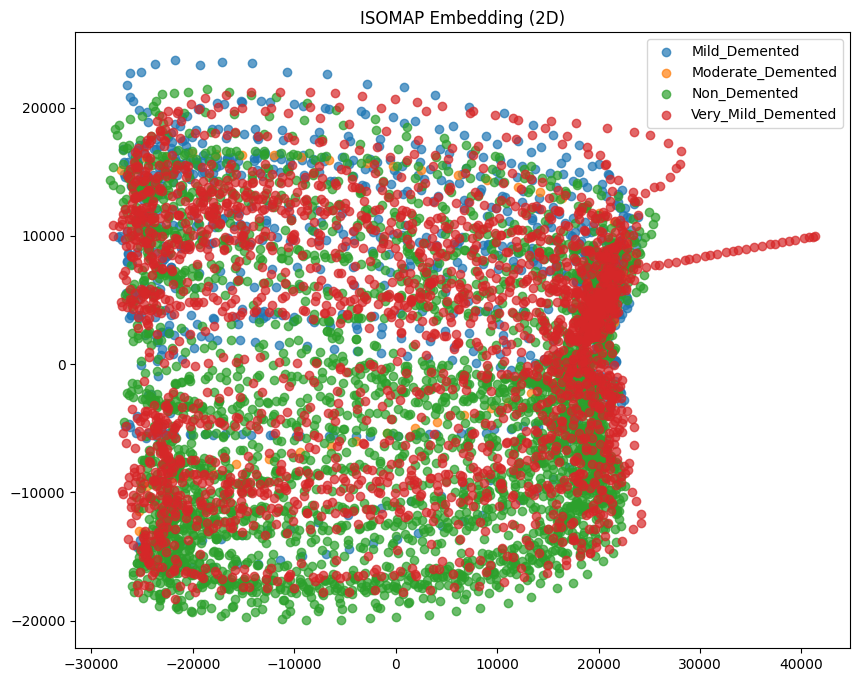

In [7]:
plot_embedding_2d(X_isomap_2d, y, 'ISOMAP Embedding (2D)')

Perform ISOMAP for 3 dimensions

In [8]:
X_isomap_3d = isomap_embedding(X, 3)

Visualise the ISOMAP Embedding for 3 dimensions

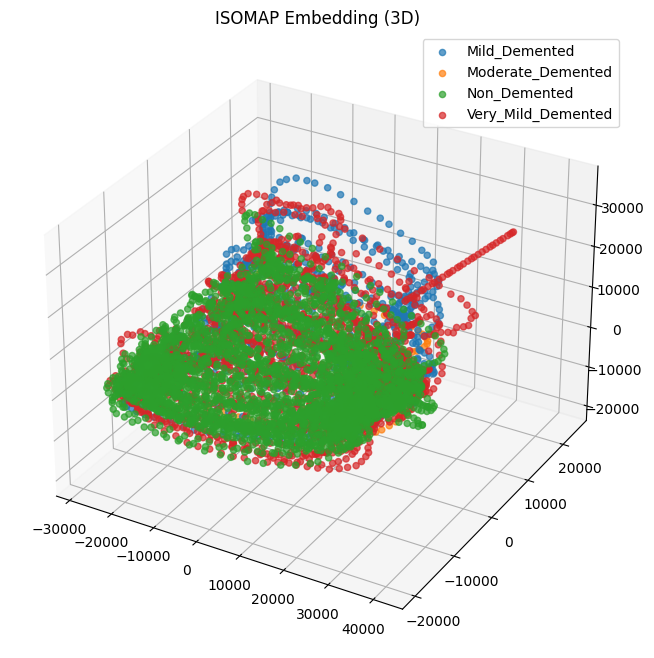

In [9]:
plot_embedding_3d(X_isomap_3d, y, 'ISOMAP Embedding (3D)')

# LLE
Create a function to apply LLE with n components

In [10]:
def lle_embedding(X, n_components):
    # Initialize LLE
    lle = LocallyLinearEmbedding(n_components=n_components)

    # Fit LLE to the preprocessed data
    X_lle = lle.fit_transform(X)
    
    return X_lle

Perform LLE for 2 dimensions

In [11]:
X_lle_2d = lle_embedding(X, 2)

Visualise the LLE Embedding for 2 dimensions

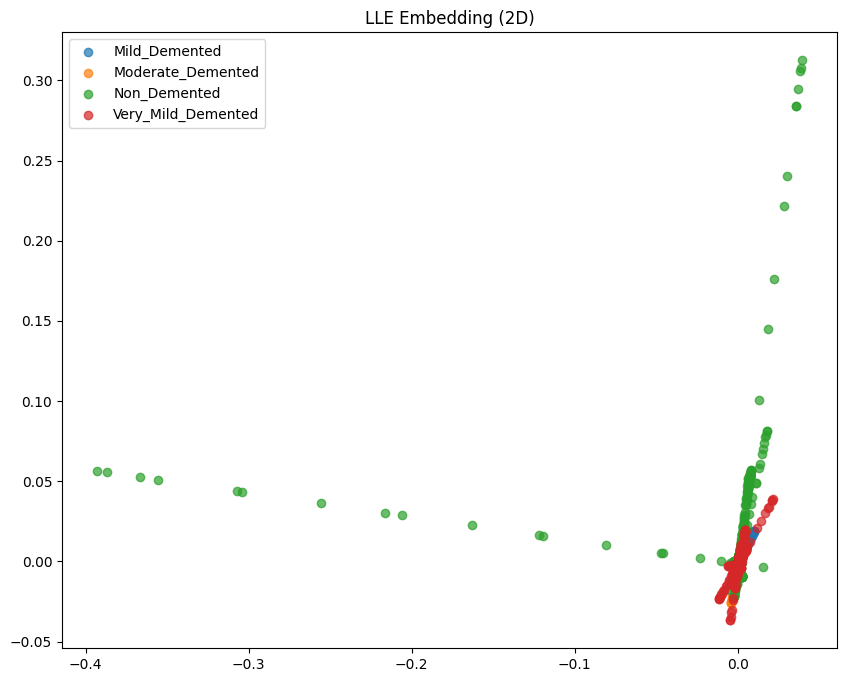

In [12]:
plot_embedding_2d(X_lle_2d, y, 'LLE Embedding (2D)')

Perform LLE for 3 dimensions

In [13]:
X_lle_3d = lle_embedding(X, 3)

Visualise the LLE Embedding for 3 dimensions

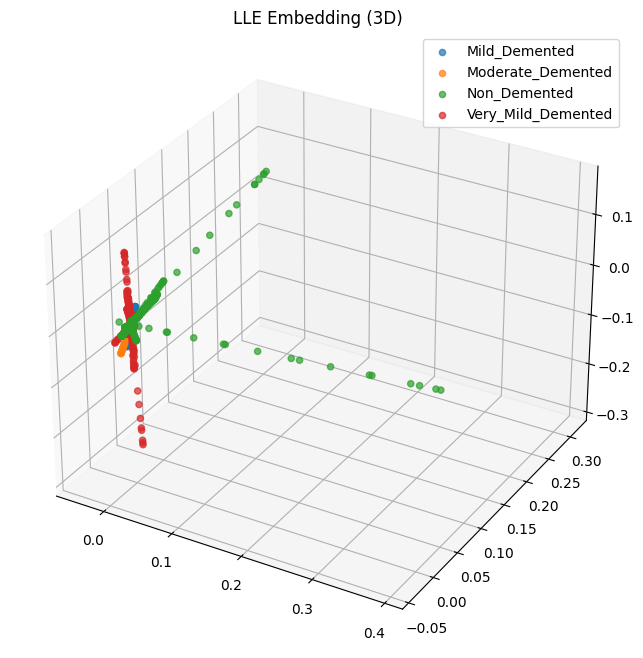

In [14]:
plot_embedding_3d(X_lle_3d, y, 'LLE Embedding (3D)')

# Diffusion Map
Create the kernel matrix

In [15]:
# Compute the pairwise distances
distances = pairwise_distances(X)

# Compute the kernel matrix
epsilon = 0.5
kernel_matrix = np.exp(-distances**2 / (2 * epsilon**2))

# Normalize the kernel matrix
D = np.diag(np.sum(kernel_matrix, axis=1)) # Degree matrix
D_inv_sqrt = np.diag(1 / np.sqrt(np.sum(kernel_matrix, axis=1))) # Inverse square root of the degree matrix
normalized_kernel_matrix = np.dot(np.dot(D_inv_sqrt, kernel_matrix), D_inv_sqrt)

Create a function to apply Diffusion Map with n components

In [16]:
def diffusion_map_embedding(X, n_components):
    # Initialize LLE
    spectral_embedding= SpectralEmbedding(n_components=n_components, affinity='precomputed')

    # Fit LLE to the preprocessed data
    X_diffusion_map = spectral_embedding.fit_transform(normalized_kernel_matrix)
    
    return X_diffusion_map

Perform Diffusion Map for 2 dimensions

In [17]:
X_diffusion_map_2d = diffusion_map_embedding(X, 2)

c:\users\sergi\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


Visualise the Diffusion Map Embedding for 2 dimensions

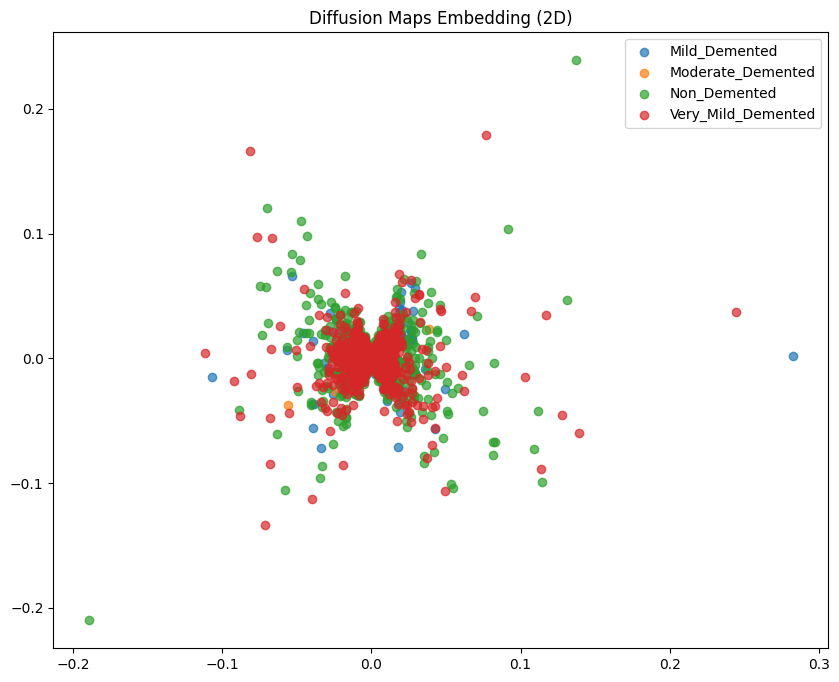

In [18]:
plot_embedding_2d(X_diffusion_map_2d, y, 'Diffusion Maps Embedding (2D)')

Perform Diffusion Map for 2 dimensions

In [19]:
X_diffusion_map_3d = diffusion_map_embedding(X, 3)

c:\users\sergi\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


Visualise the Diffusion Map Embedding for 3 dimensions

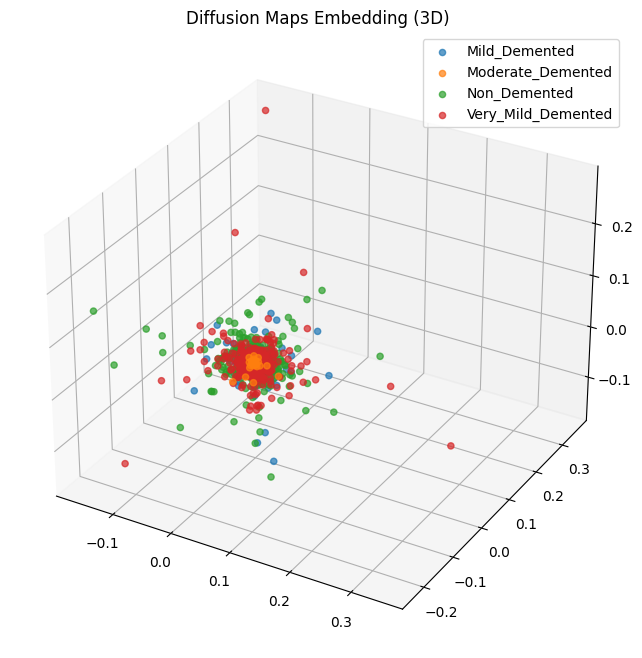

In [20]:
plot_embedding_3d(X_diffusion_map_3d, y, 'Diffusion Maps Embedding (3D)')

# Comparing the Results (Metrics)
Compute the folloeing metrics: the Calinski-Harabasz Index, the Davies-Bouldin Index, the Fowlkes-Mallows Index and the Silhouette Score.

In [21]:
# Define the datasets labels dictionary
datasets = { "Base Dataset": X, "Isomap 2D": X_isomap_2d, "Isomap 3D": X_isomap_3d,
    "LLE 2D": X_lle_2d, "LLE 3D": X_lle_3d,
    "Diffusion Map 2D": X_diffusion_map_2d, "Diffusion Map 3D": X_diffusion_map_3d}

# Initialize lists to store the results
results_ch = []
results_db = []
results_fm = []
results_sil = []

# Compute the metrics for each dataset
for name, data in datasets.items():
    kmeans = KMeans(n_clusters=len(set(y)), random_state=42).fit(data)
    y_pred = kmeans.labels_
    
    ch_score = calinski_harabasz_score(data, y)
    db_score = davies_bouldin_score(data, y)
    fm_score = fowlkes_mallows_score(y, y_pred)
    sil_score = silhouette_score(data, y)

    results_ch.append([name, ch_score])
    results_db.append([name, db_score])
    results_fm.append([name, fm_score])
    results_sil.append([name, sil_score])

# Convert results to DataFrames
df_ch = pd.DataFrame(results_ch, columns=['Algorithm', 'Calinski-Harabasz Index'])
df_db = pd.DataFrame(results_db, columns=['Algorithm', 'Davies-Bouldin Index'])
df_fm = pd.DataFrame(results_fm, columns=['Algorithm', 'Fowlkes-Mallows Index'])
df_sil = pd.DataFrame(results_sil, columns=['Algorithm', 'Silhouette Score'])

Plot the Calinski-Harabasz Index

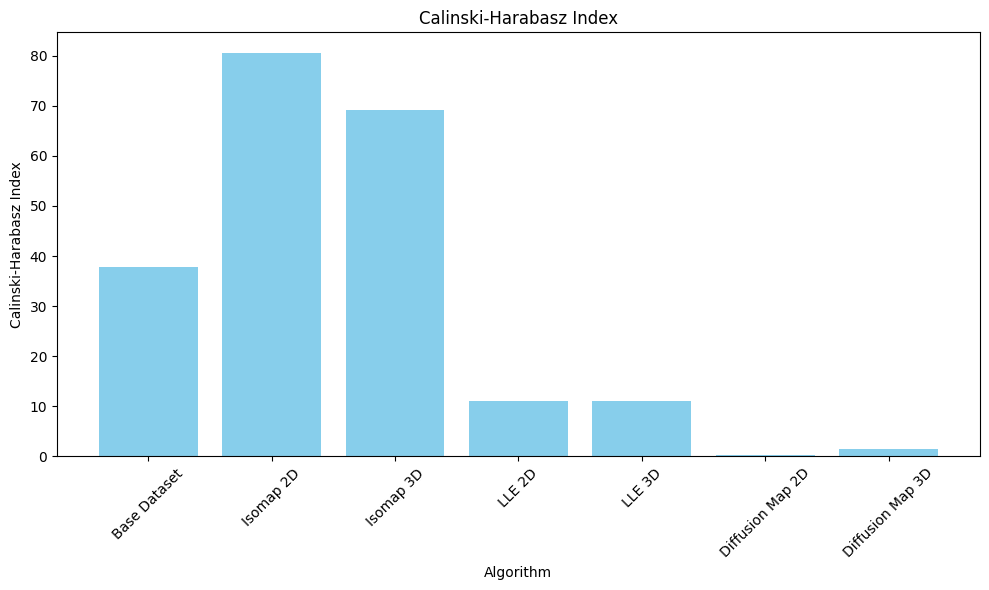

          Algorithm  Calinski-Harabasz Index
0      Base Dataset                37.762006
1         Isomap 2D                80.615847
2         Isomap 3D                69.167175
3            LLE 2D                11.098106
4            LLE 3D                10.996944
5  Diffusion Map 2D                 0.270866
6  Diffusion Map 3D                 1.520806


In [22]:
plot_metrics(df_ch, 'Calinski-Harabasz Index', 'Calinski-Harabasz Index')
print(df_ch)

Plot the Davies-Bouldin Index

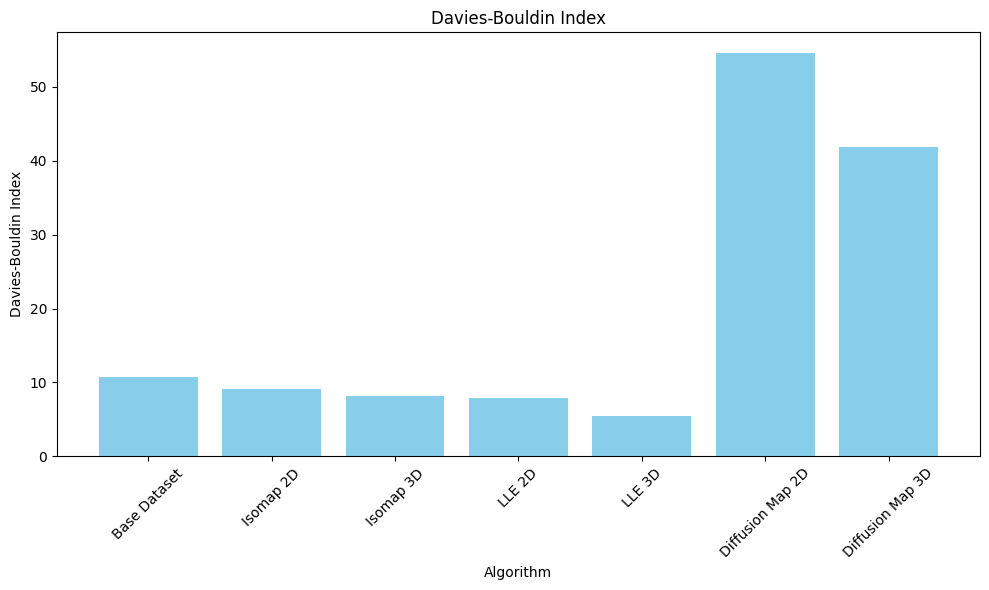

          Algorithm  Davies-Bouldin Index
0      Base Dataset             10.674452
1         Isomap 2D              9.104496
2         Isomap 3D              8.199793
3            LLE 2D              7.921122
4            LLE 3D              5.403545
5  Diffusion Map 2D             54.633159
6  Diffusion Map 3D             41.914798


In [23]:
plot_metrics(df_db, 'Davies-Bouldin Index', 'Davies-Bouldin Index')
print(df_db)

Plot the Fowlkes-Mallows Index

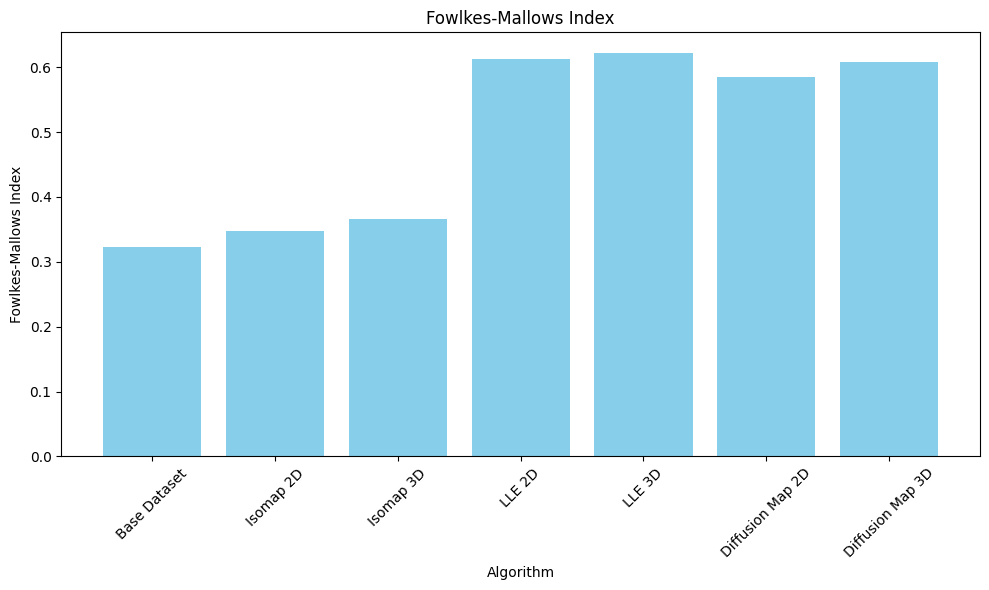

          Algorithm  Fowlkes-Mallows Index
0      Base Dataset               0.323220
1         Isomap 2D               0.347539
2         Isomap 3D               0.366212
3            LLE 2D               0.612111
4            LLE 3D               0.622544
5  Diffusion Map 2D               0.584740
6  Diffusion Map 3D               0.607608


In [24]:
plot_metrics(df_fm, 'Fowlkes-Mallows Index', 'Fowlkes-Mallows Index')
print(df_fm)

Plot the Silhouette Score

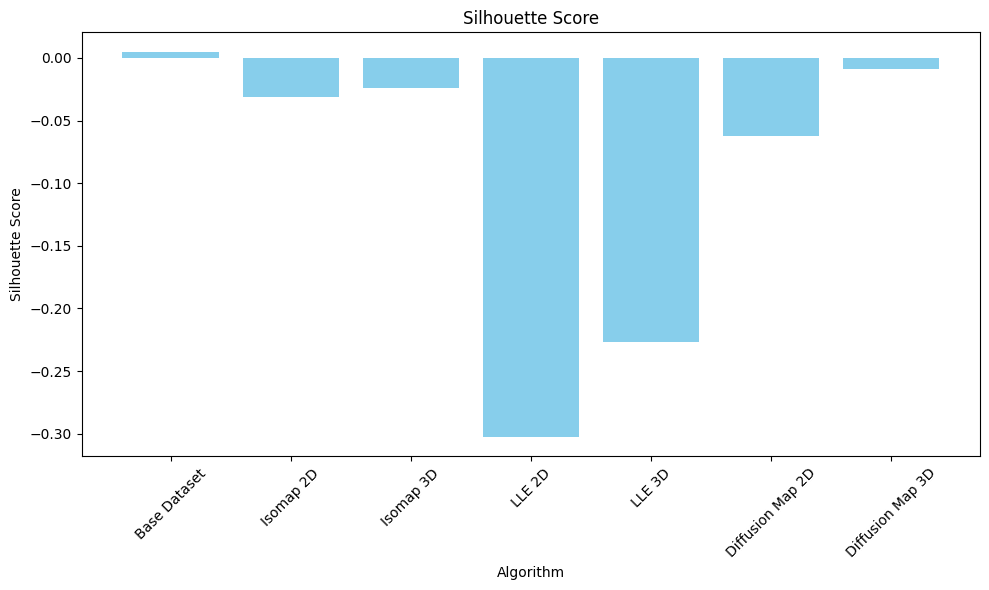

          Algorithm  Silhouette Score
0      Base Dataset          0.005043
1         Isomap 2D         -0.031247
2         Isomap 3D         -0.023651
3            LLE 2D         -0.302802
4            LLE 3D         -0.226643
5  Diffusion Map 2D         -0.062686
6  Diffusion Map 3D         -0.008519


In [25]:
plot_metrics(df_sil, 'Silhouette Score', 'Silhouette Score')
print(df_sil)

# Comparing the Results (Classification Algorithm)
Create a function that classifies the data and computes the popular metrics (accuracy, precision, recall and F1-score)

In [26]:
def evaluate_classification(X, y, algorithm_name):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the classifier
    clf = RandomForestClassifier(random_state=42)
    
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Compute the metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Return the results as a dictionary
    return {
        'Algorithm': algorithm_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    }

Compare the impact of the datasets

In [27]:
# Define the datasets labels dictionary
datasets = { "Base Dataset": X, "Isomap 2D": X_isomap_2d, "Isomap 3D": X_isomap_3d,
    "LLE 2D": X_lle_2d, "LLE 3D": X_lle_3d,
    "Diffusion Map 2D": X_diffusion_map_2d, "Diffusion Map 3D": X_diffusion_map_3d}

# Initialize a list to store the results
classification_results = []

# Evaluate the classification performance on each dataset
for name, data in datasets.items():
    result = evaluate_classification(data, y, name)
    classification_results.append(result)

# Convert the results to a DataFrame for better visualization
df_results = pd.DataFrame(classification_results)

c:\users\sergi\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plot the Accuracy

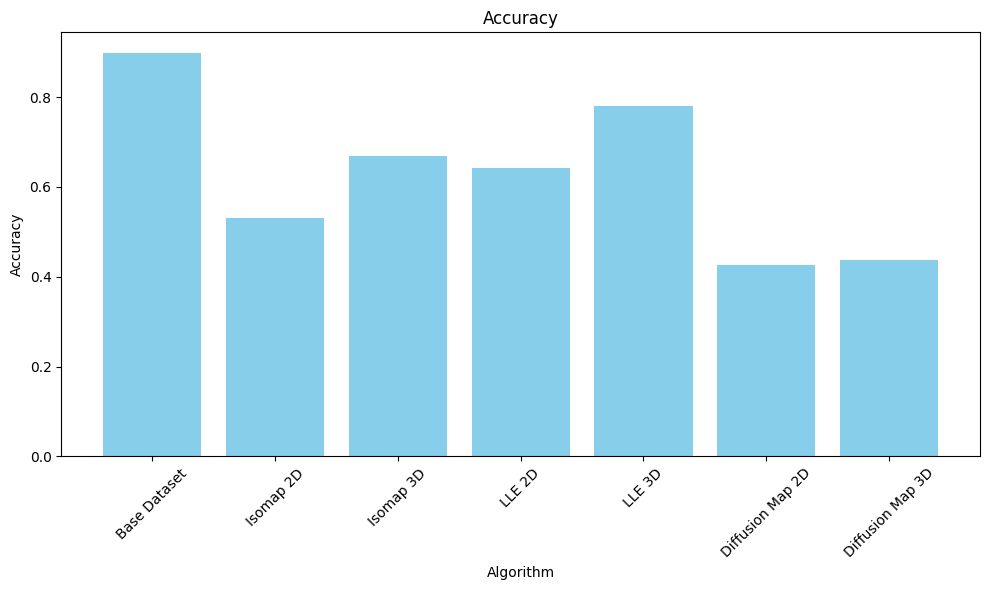

In [28]:
plot_classification_results(df_results, 'Accuracy')

Plot the Precision

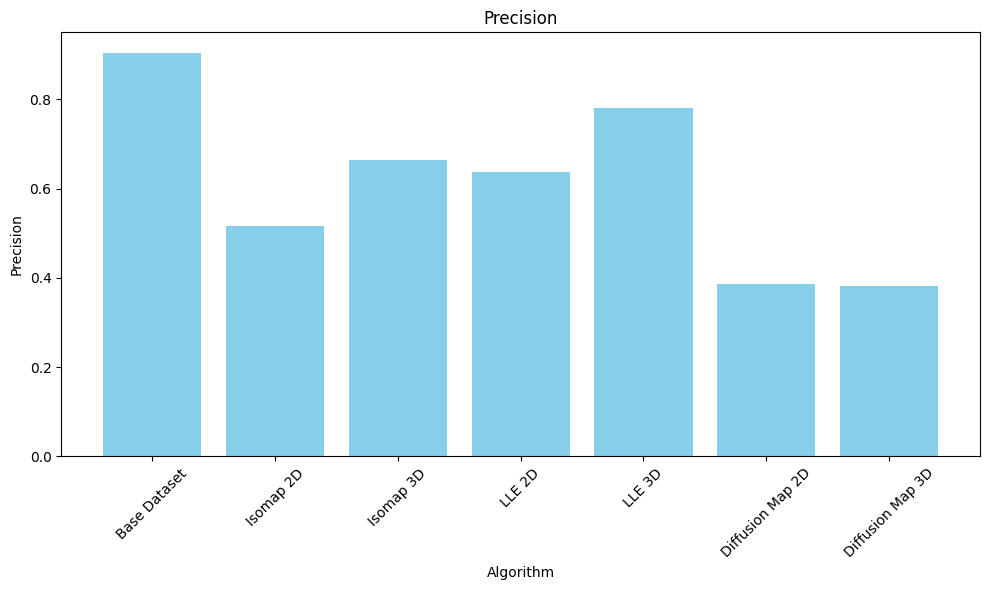

In [29]:
plot_classification_results(df_results, 'Precision')

Plot the Recall

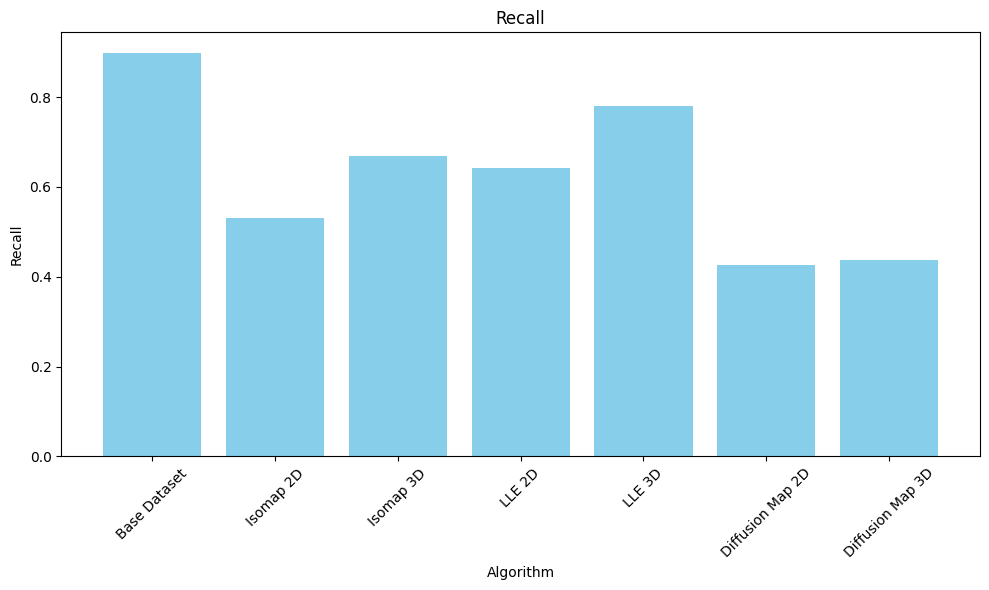

In [30]:
plot_classification_results(df_results, 'Recall')

Plot the F1-score

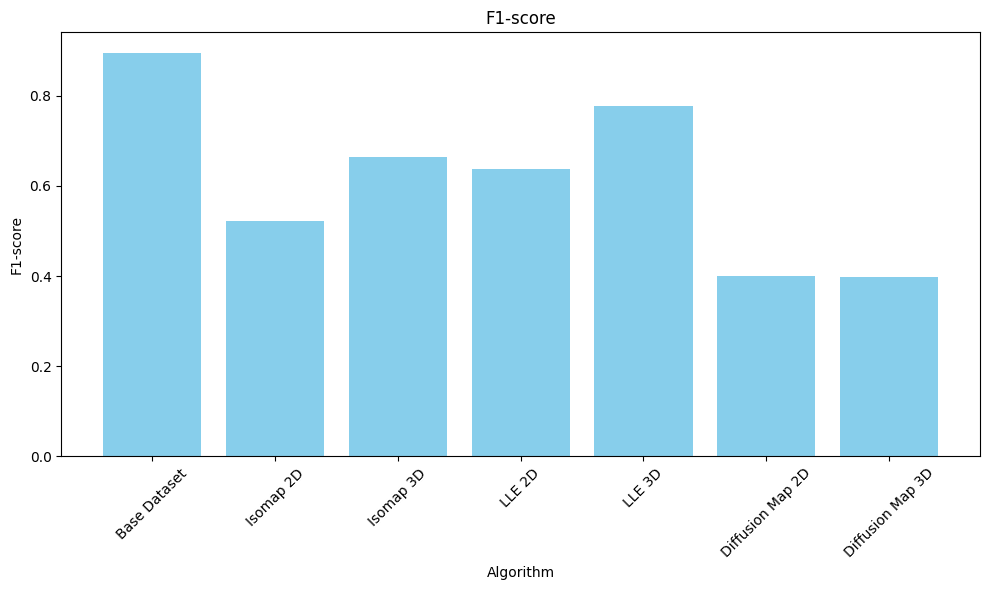

In [31]:
plot_classification_results(df_results, 'F1-score')

In [32]:
print(df_results)

          Algorithm  Accuracy  Precision    Recall  F1-score
0      Base Dataset  0.899479   0.904881  0.899479  0.895925
1         Isomap 2D  0.530729   0.516793  0.530729  0.521991
2         Isomap 3D  0.669792   0.664117  0.669792  0.663412
3            LLE 2D  0.642708   0.636774  0.642708  0.637643
4            LLE 3D  0.780729   0.779875  0.780729  0.776980
5  Diffusion Map 2D  0.426042   0.387217  0.426042  0.399793
6  Diffusion Map 3D  0.436458   0.381399  0.436458  0.396960
